**Extracción de características para análisis de imágenes médicas**

**Objetivo**

Crear una base de datos de imágenes médicas de tumores cerebrales de alto y bajo grado, extrayendo características de textura y forma para posteriormente hacer la predicción del grado utilizando aprendizaje automático.

## Preparación del entorno


In [ ]:
#Instalación de los módulos faltantes
!pip install SimpleITK
!pip install mahotas
!pip install gdown

#Importación de algunos módulos a utilizar
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob

     |████████████████████████████████| 47.4MB 92kB/s 
     |████████████████████████████████| 5.7MB 3.4MB/s 


# Sección nueva

# Sección nueva

In [ ]:
import gdown
!gdown --id 1jn7az_tfDQiiLNiUy3TdhPiNcFp2bGId
!unzip Gliomas.zip

Downloading...
From: https://drive.google.com/uc?id=1jn7az_tfDQiiLNiUy3TdhPiNcFp2bGId
To: /content/Gliomas.zip
225MB [00:02, 82.5MB/s]
Archive:  Gliomas.zip
   creating: Gliomas Images/
   creating: Gliomas Images/HG/
   creating: Gliomas Images/HG/0001/
   creating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_Flair/
  inflating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_Flair/License_CC_BY_NC_SA_3.0.txt  
  inflating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.684.mha  
   creating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_T1/
  inflating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_T1/License_CC_BY_NC_SA_3.0.txt  
  inflating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_T1/VSD.Brain.XX.O.MR_T1.685.mha  
   creating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_T1c/
  inflating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_T1c/License_CC_BY_NC_SA_3.0.txt  
  inflating: Gliomas Images/HG/0001/VSD.Brain.XX.O.MR_T1c/VSD.Brain.XX.O.MR_T1c.686.mha  
   creating: Gliomas Images/HG

## Funciones de apoyo

In [ ]:
def leer_imagen(ruta):
    """
    ruta <- str: Cadena con la ruta de la imagen a leer
    ret -> tuple(array, dict): Devuelve una tupla con el arreglo que
                            contiene a la imagen y un diccionario con 
                            los datos del encabezado
    """
    sitk_img = sitk.ReadImage(ruta)
    encabezado = {MD: sitk_img.GetMetaData(MD) for MD in sitk_img.GetMetaDataKeys()}
    pixel_data = sitk.GetArrayFromImage(sitk_img)
    return pixel_data, encabezado

def mostrar_img(img, cmap='gray'):
    """
    img <- array: Arreglo de la imagen a mostrar
    """
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def mostrar_corte(pixel_data, corte):
    """
    pixel_data <- array: Arreglo de la imagen médica con todos los cortes
    corte <- int: Número de corte a mostrar
    """
    mostrar_img(pixel_data[:,:,corte])
    return pixel_data[:,:,corte]

def obtener_rutas(dir, tipos=None):
    """
    dir <- str: Cadena con la ruta de la carpeta donde se encuentran los datos.
                La carpeta debe tener dos subcarpetas HG y LG. A su vez, cada 
                una de estas debe tener una carpeta que contenga una carpeta
                por cada imagen de cada tipo:
                    * Flair
                    * T1
                    * T1c
                    * T2
                    * Máscara (que contiene la palabra 'more')
    tipos <- list: Lista con los tipos que se desean obtener. Los tipos válidos
                    dene encontrarse en ['Flair', 'T1', 'T1c', 'T2']
    
    rutas -> dict: Diccionario que contiene las rutas de cada imagen organizada 
                    de la siguiente manera:
                        rutas[Grado][Num][Tipo]
                    donde Grado: 'HG' o 'LG'
                          Num: Entero correspondiente al número de la carpeta
                                de las imágenes
                          Tipo: 'Flair', 'T1', 'T1c', 'T2' o 'mask'
    """
    if tipos is None: tipos = ['Flair', 'T1', 'T1c', 'T2']
    rutas = {'HG':{},
            'LG' :{}}
    for grade in ['HG', 'LG']:
        imgs_folder = os.listdir(os.path.join(dir, grade))
        #print(imgs_folder)
        for folder in imgs_folder:
            try:
                rutas[grade][int(folder)]={}
            except:
                print(f'No se guardo la carpeta {grade}/{folder}')
                continue
            imgnames = os.listdir(os.path.join(dir, grade, folder))
            for img in imgnames:
                if 'more' in img:
                    tipo = 'mask'
                else:
                    tipo = img.split('_')[-1]
                    if tipo not in tipos:
                        continue
                path = glob(os.path.join(dir, grade, folder, img,img+'*'))
                if len(path)>0:
                    rutas[grade][int(folder)][tipo] = path[0]
    return rutas


def devolver_validos(cortes, masks, etiquetas=[1,4], inter = 2):
    """
    cortes <- array(MxNxQ): Arreglo de la imagen médica de tamaño MxNxQ, donde q es la
                    cantidad de cortes disponibles
    masks <- array(MxNxQ): Arreglo de las mismas dimensiones de cortes, con la información
                    de las máscaras de segmentación con etiquetas de 0-4
    etiquetas <- list(int): Estiquetas que se desean considerar como válidas
    inter <- int: Intervalo de cortes a considerar, partiendo de la máscara con la región
                de mayor área.

    valid_cortes -> array(MxNx(inter*2+1)): Arreglo de la imagen médica con los cortes 
                                            válidos encontrados
    valid_masks -> array(MxNx(inter*2+1)): Arreglo de las máscaras válidas
    """
    unicos = np.unique(masks).tolist()
    etiquetas_validas = [e for e in etiquetas if e in unicos]
    assert len(etiquetas_validas)>0, 'No hay mascaras válidas'
    candidatos = [masks==n for n in etiquetas_validas]
    seleccionados = candidatos[0]
    if len(candidatos)>1:
        for c in candidatos[1:]:
            seleccionados = np.logical_or(seleccionados, c)

    i_max = np.argmax([np.count_nonzero(seleccionados[...,r]) for r in range(seleccionados.shape[2])])

    valid_masks = seleccionados[..., i_max-inter:i_max+inter+1]
    valid_cortes = cortes[..., i_max-inter:i_max+inter+1]
    return valid_cortes, valid_masks, i_max

## Revisión de los datos

In [ ]:
# Se obtienen todas las rutas disponibles de las imágenes
# tipos <- arreglo de valores tipo ['T1', 'T1c', 'T2', 'Flair']
rutas = obtener_rutas('/content/Gliomas Images', tipos = ['T1','T1c'])

for grado in rutas:
    disp = [str(i) for i in sorted(rutas[grado].keys())]
    print(f'Disponibles para grado {grado}: {", ".join(disp)}')

Disponibles para grado HG: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 24, 25, 26, 27
Disponibles para grado LG: 1, 2, 4, 6, 8, 11, 12, 13, 14, 15


Dimensiones cortes: (176, 216, 160)
Dimensiones máscaras: (176, 216, 160)


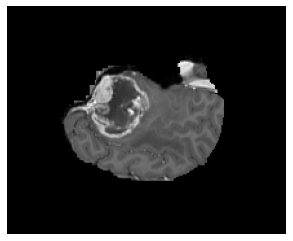

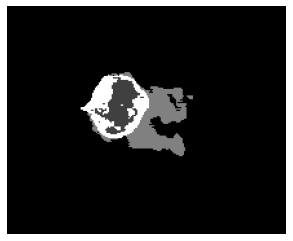

Tipos disponibles [0 1 2 3 4]


In [ ]:
#Visualizar uno de los datos

#Seleccion de las imágenes
fname = rutas['HG'][1]['T1c']
masks_fname = rutas['HG'][1]['mask']

#Lectura de las imágenes
cortes, _ = leer_imagen(fname)
masks, _ = leer_imagen(masks_fname)
print(f'Dimensiones cortes: {cortes.shape}')
print(f'Dimensiones máscaras: {masks.shape}')


#Mostrar un corte de las imágenes
corte = cortes[:, :, 30]
mask = masks[:,:, 30]
mostrar_img(corte)
mostrar_img(mask)

print(f'Tipos disponibles {np.unique(mask)}')

## Seleccionando las máscaras de interés

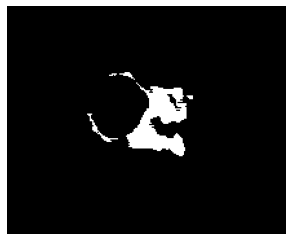

In [ ]:
#Hay 4 tipos de segmentaciones en cada imagen de máscara,
#cada una identificada por un valor entre 1-4
#1 necrosis - 2 edema - 3 region sin contraste - 4 Region activa (contrastada)
mascara_seleccionada = mask==1
mostrar_img(mascara_seleccionada)

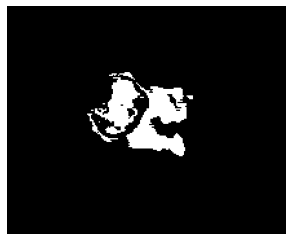

El área es de: 2205px


In [ ]:
#Seleccionar más de una máscara
mascara1 = mask==1
mascara2 = mask==2

#Se genera una máscara binaria
#np.logical_or(mascara1, mascara2)
mascara_seleccionada = np.logical_or(mascara1, mascara2)
mostrar_img(mascara_seleccionada)

# Medición del área de la region
area = np.count_nonzero(mascara_seleccionada)
print(f'El área es de: {area}px')

## Seleccionando un conjunto de máscaras cercanas a la de mayor área

In [ ]:
n_cortes = masks.shape[2]
print(f'Se tienen {n_cortes} cortes disponibles')
areas=dict()
for i in range(n_cortes):
    #corte_img = cortes[:,:,i]
    corte_mask = masks[:,:,i]
    #Se selecciona el tipo de máscara de interés
    mascara1 = corte_mask==1 #llenar
    mascara2 = corte_mask==2 #llenar
    mascara_seleccionada = np.logical_or(mascara1, mascara2)
    # Medición del área de la region
    area = np.count_nonzero(mascara_seleccionada)
    #print(f'Corte {i}, area {area}px')
    areas[i]=area

Se tienen 160 cortes disponibles


In [ ]:
print(max(areas,key=areas.get))
print(max(areas.values()))
#areas[33]

43
2616


imagen corte 43


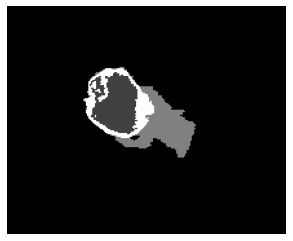

imagen corte 50


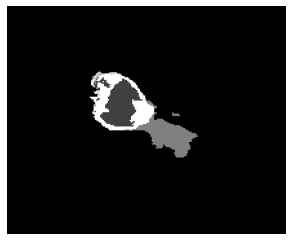

In [ ]:
#Mostrar corte de mayor área
print("imagen corte 43")
mostrar_corte(masks, 43); #llenar
print("imagen corte 50")
mostrar_corte(masks, 50); #llenar

Indice de corte 41
Indice de corte valido 0


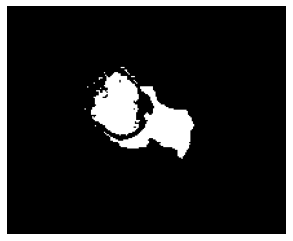

Indice de corte 42
Indice de corte valido 1


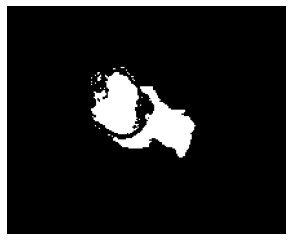

Indice de corte 43
Indice de corte valido 2


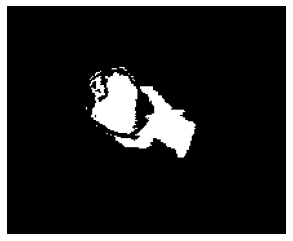

Indice de corte 44
Indice de corte valido 3


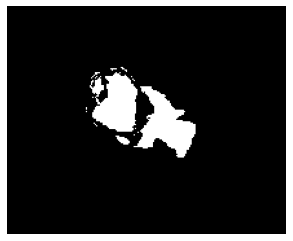

Indice de corte 45
Indice de corte valido 4


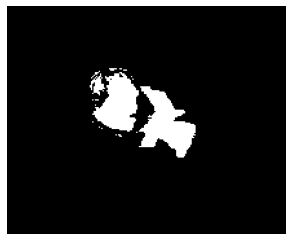

(176, 216, 5)


In [ ]:
#Seleccion de la máscara de mayor región y el intervalo
inter = 2 #llenar
i_max = 43 #llenar
mascaras_validas = masks[:,:,i_max-inter: i_max+inter+1]

#Seleccion de los tipos de máscaras de interés
mascaras_validas = np.logical_or(mascaras_validas==1, #llenar
                                 mascaras_validas==2) #llenar

for i in range(inter*2+1):
    print(f'Indice de corte {i_max-inter+i}')
    print(f'Indice de corte valido {i}')
    mostrar_corte(mascaras_validas, i)

print(mascaras_validas.shape)

Dimensiones cortes: (176, 216, 5)
Dimensiones máscaras: (176, 216, 5)
Indice del corte con área máxima: 43


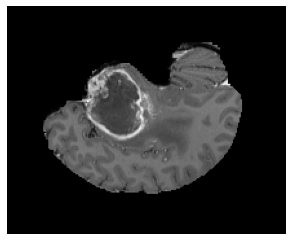

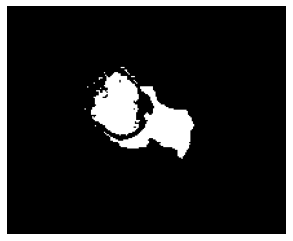

In [ ]:
##Usando la función 
valid_cortes, valid_masks, i_max = devolver_validos(cortes,
                                                    masks,
                                                    etiquetas = [1,2], #llenar
                                                    inter=2)
print(f'Dimensiones cortes: {valid_cortes.shape}')
print(f'Dimensiones máscaras: {valid_masks.shape}')
print(f'Indice del corte con área máxima: {i_max}')

mostrar_corte(valid_cortes, 0)
mostrar_corte(valid_masks, 0);

# Extracción de características

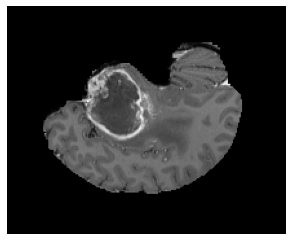

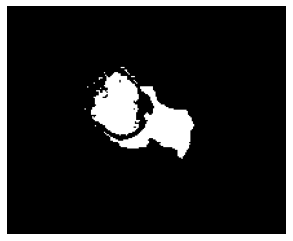

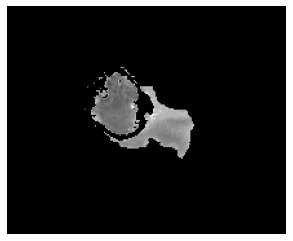

In [ ]:
#Obtención del corte de trabajo
corte = mostrar_corte(valid_cortes, 0)
mask = mostrar_corte(valid_masks,0)

#Aplicación de la máscara de segmentación sobre la imagen
segmentada = corte*mask

#Se muestra el resultado de la segmentación
mostrar_img(segmentada)

##Textura

Revisar documentación de [https://mahotas.readthedocs.io/en/latest/api.html#mahotas.features.haralick](https://mahotas.readthedocs.io/en/latest/api.html#mahotas.features.haralick)

In [ ]:
from mahotas.texture import haralick

#Definición de los nombres de las características
names = ['Angular Second Moment','Contrast','Correlation','Variance','Inverse Difference Moment',
                  'Sum Average','Sum Variance','Sum Entropy','Entropy','Difference Variance',
                  'Difference Entropy','Info Correlation 1','Info Correlation 2']

In [ ]:
#Obtención de las características
caract = haralick(segmentada,
                  distance=1,
                  return_mean=True)
print(caract)
print(f'Dimensiones: {caract.shape}')

##Si no se obtiene el promedio:
#names = [h+'_'+n for n in ['d1','d2','d3','d4'] for h in names]
#print(names)

[ 8.56699052e-01  3.25627424e+03  8.85958697e-01  1.42724171e+04
  9.28374756e-01  6.37336973e+01  5.38333943e+04  1.08022131e+00
  1.28521247e+00  1.04807655e-03  8.91947681e-01 -6.36597412e-01
  8.35905890e-01]
Dimensiones: (13,)


## Forma
Revisar documentación de [https://scikit-image.org/docs/0.16.x/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops](https://scikit-image.org/docs/0.16.x/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops)

In [ ]:
from skimage.measure import regionprops

region_props = regionprops(mask.astype(np.uint0), corte)[0]
region_props

In [ ]:
#Obtener atributos de las regiones:
propiedades = ['area', 'max_intensity', 'orientation']
for prop in propiedades:
    print(f'{prop}: {getattr(region_props, prop)}')

area: 2614
max_intensity: 817
orientation: 1.1100156776166643


#Poniendo todo junto

In [ ]:
from mahotas.texture import haralick
from skimage.measure import regionprops
import pandas as pd
from glob import glob

INTER = 2
HARALICK_DIST = 2
HARALICK_MEAN = True
MOSTRAR_IMGS = True

#Colocar None para utilizar todos los tipos 
#o una lista con los tipos entre ['Flair', 'T1', 'T1c', 'T2']
TIPOS = ['T1c']

ETIQUETAS = [1,3]

prop_car = ['area', 'max_intensity', 'orientation']

#----------------------------------------------------------------------------------------------

names = ['Angular Second Moment','Contrast','Correlation','Variance','Inverse Difference Moment',
                  'Sum Average','Sum Variance','Sum Entropy','Entropy','Difference Variance',
                  'Difference Entropy','Info Correlation 1','Info Correlation 2']
                  
if not HARALICK_MEAN: 
    names = [h+'_'+n for n in ['d1','d2','d3','d4'] for h in names]

names.extend(prop_car)
names.extend(['Tipo','Grado'])

grados_dict = {'HG':1, 'LG':0}
tipos_dict = {'T1':0, 'T1c':1, 'T2':2, 'Flair':3}

imgs_rutas = obtener_rutas('/content/Gliomas Images', tipos = TIPOS)

data = []
counter = 0
for grado in imgs_rutas:
    for folder in imgs_rutas[grado]:
        masks,_ = leer_imagen(imgs_rutas[grado][folder]['mask'])
        for tipo in imgs_rutas[grado][folder]:
            if tipo=='mask':continue
            print(f'Revisando imagenes {grado}-{folder}-{tipo}.', end='')
            cortes,_ = leer_imagen(imgs_rutas[grado][folder][tipo])
            try:
                valid_cortes, valid_masks, _ = devolver_validos(cortes, masks, inter=INTER, etiquetas=ETIQUETAS)
            except:
                print('... No hay máscaras válidas... Saltando.')
                continue
            ncortes = valid_cortes.shape[2]
            print(f' Cortes validos = {ncortes}')
            if MOSTRAR_IMGS:
                mostrar_corte(valid_cortes, INTER)
                mostrar_corte(valid_masks, INTER)
            print('\tProcesando corte ', end='')
            for corte_i in range(ncortes):
                print(f'{corte_i+1}... ', end='')
                mask = valid_masks[:,:,corte_i]
                corte = valid_cortes[:,:,corte_i]
                segmentada = corte*mask
                har_car = haralick(segmentada,
                                   ignore_zeros=False,
                                   distance=HARALICK_DIST,
                                   return_mean=HARALICK_MEAN).flatten()
                reg_props=regionprops(mask.astype(np.uint0), corte)
                if len(reg_props)==0:
                    print('Saltando... No reg_props')
                    continue
                reg_props_arr = [getattr(reg_props[0], prop) for prop in prop_car]
                por_corte = har_car.tolist() + reg_props_arr
                data.append(por_corte + [tipos_dict[tipo], grados_dict[grado]])
            print('Imágenes procesadas', end='\n')

In [ ]:
##Se genera el dataframe
data_arr = np.array(data)
n_muestras, n_caract = data_arr.shape
print(f'Se tienen {n_muestras} muestras con {n_caract-2} características')
df = pd.DataFrame(data_arr, columns = names)
df.head(-10)

Se tienen 145 muestras con 16 características


,Angular Second Moment,Contrast,Correlation,Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Info Correlation 1,Info Correlation 2,area,max_intensity,orientation,Tipo,Grado
0,0.918319,1969.484929,0.698848,3267.690349,0.958956,20.791166,11101.276468,0.612380,0.696011,0.001720,0.575986,-0.470618,0.589603,1231.0,532.0,-0.973472,1.0,1.0
1,0.918305,1898.525912,0.711276,3285.086449,0.959011,20.958470,11241.819885,0.612302,0.697953,0.001724,0.573013,-0.473007,0.591597,1241.0,531.0,-0.971478,1.0,1.0
2,0.917525,1770.303688,0.738522,3382.378818,0.958595,21.582211,11759.211586,0.619879,0.709395,0.001709,0.577401,-0.493033,0.608629,1279.0,535.0,-0.940886,1.0,1.0
3,0.920407,1665.463845,0.744042,3250.649373,0.960045,20.796296,11337.133647,0.598188,0.683468,0.001910,0.556848,-0.498129,0.603012,1234.0,480.0,-0.941628,1.0,1.0
4,0.926260,1691.827750,0.718446,3002.000632,0.963074,18.983903,10316.174780,0.557395,0.630945,0.001922,0.521591,-0.486666,0.576848,1118.0,480.0,-0.973915,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.833329,3760.468935,0.782548,8643.822965,0.914895,52.315432,30814.822927,1.194865,1.456406,0.001551,1.075678,-0.482411,0.776974,3077.0,536.0,-1.488045,1.0,0.0
131,0.832883,3474.918557,0.799381,8657.515446,0.914636,52.727662,31155.143229,1.199165,1.467477,0.001635,1.074447,-0.485950,0.781025,3116.0,508.0,-1.524181,1.0,0.0
132,0.831478,3219.799787,0.814366,8669.118072,0.914195,53.339114,31456.672501,1.211236,1.486507,0.001471,1.076758,-0.496980,0.790992,3182.0,564.0,-1.534147,1.0,0.0
133,0.832256,3167.159595,0.813319,8478.570376,0.914583,52.535770,30747.121910,1.210345,1.483552,0.001475,1.074503,-0.496725,0.790305,3162.0,563.0,-1.546962,1.0,0.0


# Separabilidad

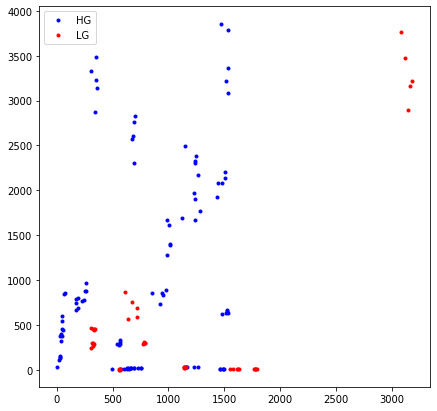

In [ ]:
#Visualización de características en 2 dimensiones
caract1 = 'area'
caract2 = 'Sum Average' #True en el codigo de arriba sobre haralik
caract2 = 'Contrast' #True en el codigo de arriba sobre haralik

hg = df[df.Grado==1]
lg = df[df.Grado==0]

plt.figure(figsize=(7,7))
plt.plot(hg[caract1], hg[caract2], 'b.', label='HG')
plt.plot(lg[caract1], lg[caract2], 'r.', label='LG')
plt.legend()
plt.show()

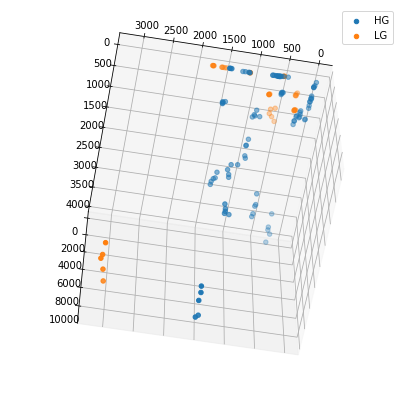

In [ ]:
#Visualización de características en 3 dimensiones
from mpl_toolkits.mplot3d import Axes3D

caract1 = 'area'
caract2 = 'Sum Average'
caract2 = 'Contrast'
caract3 = 'Variance'


rot_y = 120
rot_x = 100
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(rot_y, rot_x)
ax.scatter(hg[caract1], hg[caract2], hg[caract3], 'b.', label='HG')
ax.scatter(lg[caract1], lg[caract2], lg[caract3], 'r.', label='LG')

plt.legend()
plt.show()

## PCA
Para mayor información sobre el análisis de componentes principales, visitar https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0

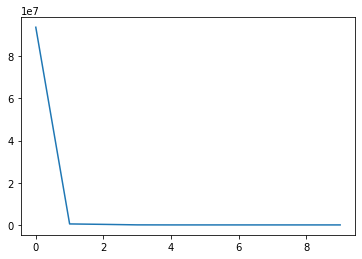

In [ ]:
from sklearn.decomposition import PCA

#Se seleccionan los datos de nuestro DataFrame
X = df.iloc[:,:-1]
y = df.Grado

#Se indica el número de componentes a conservar
n_componentes = 10
pca = PCA(n_components = n_componentes)
X = pca.fit_transform(X)

plt.plot(pca.explained_variance_)
plt.show()

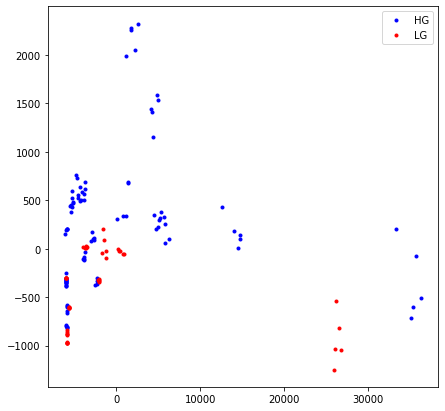

In [ ]:
#Visualización de los dos primeros componentes
hg = X[y==1]
lg = X[y==0]

plt.figure(figsize=(7,7))
plt.plot(hg[:, 0], hg[:, 1], 'b.', label='HG')
plt.plot(lg[:, 0], lg[:, 1], 'r.', label='LG')
plt.legend()

plt.show()

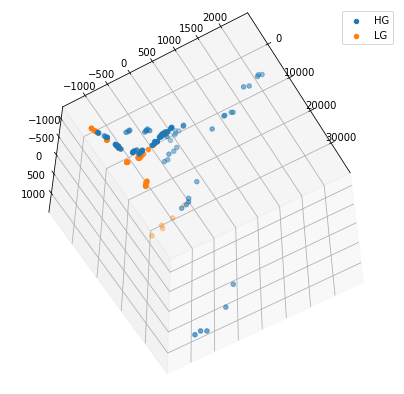

In [ ]:
rot_y = 120
rot_x = -30
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(rot_y, rot_x)
ax.scatter(hg[:, 0], hg[:, 1], hg[:, 2], 'b.', label='HG')
ax.scatter(lg[:, 0], lg[:, 1], lg[:, 2], 'r.', label='LG')

plt.legend()
plt.show()

In [ ]:
#Se arma el nuevo DataFrame
names = [f'comp{i}' for i in range(X.shape[1])]
newdf = pd.DataFrame(X, columns = names)
newdf['Grado'] = y
newdf.head()


,comp0,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,comp9,Grado
0,5631.998604,326.346177,-406.548475,-130.085321,-2.981213,-0.267454,-0.072599,-0.073312,-0.053555,0.016603,1.0
1,5764.848138,256.108027,-360.041904,-108.966082,-3.061578,-0.281360,-0.070938,-0.066515,-0.056323,0.019827,1.0
2,6275.713642,103.461876,-268.198939,-60.574395,-3.168091,-0.278161,-0.077588,-0.057771,-0.051178,0.023787,1.0
3,5823.482124,54.438689,-208.733067,-93.613958,-3.301022,-0.356947,-0.090067,-0.057244,-0.041649,0.026174,1.0
4,4777.172763,203.562524,-222.878248,-127.320853,-2.976633,-0.454702,-0.097680,-0.062311,-0.040512,0.024290,1.0


# Guardado de datos

In [ ]:
#Se guardan los archivos para su uso posterior
df.to_csv('raw_data.csv')
newdf.to_csv('pca_data.csv')

In [ ]:
df # tipo 1 y 2

,Angular Second Moment,Contrast,Correlation,Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Info Correlation 1,Info Correlation 2,area,max_intensity,orientation,Tipo,Grado
0,0.918319,1969.484929,0.698848,3267.690349,0.958956,20.791166,11101.276468,0.612380,0.696011,0.001720,0.575986,-0.470618,0.589603,1231.0,532.0,-0.973472,1.0,1.0
1,0.918305,1898.525912,0.711276,3285.086449,0.959011,20.958470,11241.819885,0.612302,0.697953,0.001724,0.573013,-0.473007,0.591597,1241.0,531.0,-0.971478,1.0,1.0
2,0.917525,1770.303688,0.738522,3382.378818,0.958595,21.582211,11759.211586,0.619879,0.709395,0.001709,0.577401,-0.493033,0.608629,1279.0,535.0,-0.940886,1.0,1.0
3,0.920407,1665.463845,0.744042,3250.649373,0.960045,20.796296,11337.133647,0.598188,0.683468,0.001910,0.556848,-0.498129,0.603012,1234.0,480.0,-0.941628,1.0,1.0
4,0.926260,1691.827750,0.718446,3002.000632,0.963074,18.983903,10316.174780,0.557395,0.630945,0.001922,0.521591,-0.486666,0.576848,1118.0,480.0,-0.973915,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.955249,866.627589,0.660656,1276.078633,0.977730,9.256608,4237.686943,0.344569,0.384204,0.002286,0.330194,-0.564263,0.510199,611.0,416.0,-0.451502,1.0,0.0
141,0.952818,761.739118,0.704816,1289.520550,0.976534,9.727394,4396.343080,0.360587,0.407565,0.002099,0.343367,-0.601388,0.543525,671.0,452.0,-0.458957,1.0,0.0
142,0.950834,689.464257,0.742304,1336.702720,0.975604,10.292349,4657.346623,0.373523,0.425806,0.002325,0.353468,-0.621881,0.564615,722.0,407.0,-0.486974,1.0,0.0
143,0.952503,589.421057,0.773364,1299.401206,0.976401,10.151155,4608.183767,0.363285,0.413494,0.002252,0.343059,-0.652865,0.574417,715.0,421.0,-0.517696,1.0,0.0



# Analisís por logistico

Se crea un modelo logistico para el analisís de a que tipo de grupo pertenece


In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

x = df.drop(['Grado'],1)
y = df['Grado']

#dividimos los datos en entrenamiento y prueba
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

model = linear_model.LogisticRegression()
model.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(pd.DataFrame(model.predict(x_test),y_test ))
print(model.score(x_test,y_test))

         0
Grado     
1.0    1.0
0.0    1.0
1.0    0.0
1.0    1.0
0.0    0.0
0.0    1.0
0.0    0.0
1.0    1.0
1.0    0.0
1.0    1.0
1.0    0.0
0.0    1.0
1.0    1.0
1.0    0.0
1.0    1.0
1.0    1.0
1.0    0.0
1.0    1.0
1.0    1.0
1.0    1.0
0.0    0.0
0.0    0.0
1.0    1.0
1.0    1.0
1.0    1.0
1.0    1.0
1.0    1.0
0.0    0.0
1.0    0.0
0.6896551724137931


In [ ]:
from sklearn.metrics import confusion_matrix
a=confusion_matrix(y_test, pred)
print(confusion_matrix(y_test, pred))
sensi=a[0,0]/(a[0,0]+a[0,1])
Especi=a[1,1]/(a[1,1]+a[1,0])
acur=(a[1,1]+a[0,0])/a.sum()
print("\n\n Especificidad",Especi)
print("\n\n Sensibilidad",sensi)
print("\n\n Accuracy",acur)
print("\n\n Con este modelo se tuvo 4 Falsos Falsos")
print(" Con este modelo se tuvo 3 Falsos Positivos")
print(" Con este modelo se tuvo 16 Positivos Positivos")
print(" Con este modelo se tuvo 6 Positivos Falsos")

[[ 2  6]
 [ 8 13]]


 Especificidad 0.6190476190476191


 Sensibilidad 0.25


 Accuracy 0.5172413793103449


 Con este modelo se tuvo 4 Falsos Falsos
 Con este modelo se tuvo 3 Falsos Positivos
 Con este modelo se tuvo 16 Positivos Positivos
 Con este modelo se tuvo 6 Positivos Falsos


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.45      0.62      0.53         8
         1.0       0.83      0.71      0.77        21

    accuracy                           0.69        29
   macro avg       0.64      0.67      0.65        29
weighted avg       0.73      0.69      0.70        29



# Ajustes por vecinos más cercanos

Se usa el vecino el vecino más cerca

([<matplotlib.axis.XTick at 0x7f3ebd31c0b8>,
 <a list of 5 Text major ticklabel objects>)

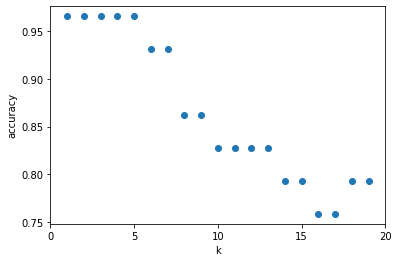

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#selección de k optimo
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    scores.append(knn.score(x_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [ ]:
n_neighbors = 2

knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train, y_train)
print('Accuracy de K-NN classifier sobre train: {:.2f}'
     .format(knn.score(x_train, y_train)))
print('Accuracy de K-NN classifier sobre test: {:.2f}'
     .format(knn.score(x_test, y_test)))

Accuracy de K-NN classifier sobre train: 0.99
Accuracy de K-NN classifier sobre test: 0.97


In [ ]:
pred = knn.predict(x_test)
print("Matriz de confunción")
a=confusion_matrix(y_test, pred)
print(confusion_matrix(y_test, pred))
sensi=a[0,0]/(a[0,0]+a[0,1])
Especi=a[1,1]/(a[1,1]+a[1,0])
acur=(a[1,1]+a[0,0])/a.sum()
print("\n\n Especificidad",Especi)
print("\n\n Sensibilidad",sensi)
print("\n\n Accuracy",acur)
print("\n\n Con este modelo se tuvo 10 Falsos Falsos Especificidad")
print(" Con este modelo se tuvo 1 Falsos Positivos")
print(" Con este modelo se tuvo 18 Positivos Positivos Sensibilidad")
print(" Con este modelo se tuvo 0 Positivos Falsos")
print("\n\n\n")
print(classification_report(y_test, pred))

Matriz de confunción
[[ 8  0]
 [ 1 20]]


 Especificidad 0.9523809523809523


 Sensibilidad 1.0


 Accuracy 0.9655172413793104


 Con este modelo se tuvo 10 Falsos Falsos Especificidad
 Con este modelo se tuvo 1 Falsos Positivos
 Con este modelo se tuvo 18 Positivos Positivos Sensibilidad
 Con este modelo se tuvo 0 Positivos Falsos




              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.95      0.98        21

    accuracy                           0.97        29
   macro avg       0.94      0.98      0.96        29
weighted avg       0.97      0.97      0.97        29

